<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Bio-NfNet-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

import os
os.kill(os.getpid(), 9)
# Restart Runtime

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4594 (delta 5), reused 19 (delta 4), pack-reused 4572
Receiving objects: 100% (4594/4594), 15.78 MiB | 24.98 MiB/s, done.
Resolving deltas: 100% (3303/3303), done.
/content/pytorch-image-models
running install
running bdist_egg
running egg_info
creating timm.egg-info
writing timm.egg-info/PKG-INFO
writing dependency_links to timm.egg-info/dependency_links.txt
writing requirements to timm.egg-info/requires.txt
writing top-level names to timm.egg-info/top_level.txt
writing manifest file 'timm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'timm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/timm
copying timm/__init__.py -> build/lib/timm
copying tim

In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-03 15:42:20--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17231696 (16M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  16.43M  61.2MB/s    in 0.3s    

2021-03-03 15:42:21 (61.2 MB/s) - ‘Dataset.7z’ saved [17231696/17231696]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 17231696 bytes (17 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dat

In [44]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

## Cleaning and getting a final data

In [4]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [5]:
data = pd.read_csv("/content/Dataset/all_meta_data.csv")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [6]:
import urllib.request as req

def download(url,file_name):
  imgurl =url
  req.urlretrieve(imgurl, file_name)

In [7]:
# Dropping unnecessary datapoints
def check_file_download(x):
  if x[1] not in imgs:
    download(*x)


data['image_path_url'] = data[['image_url','img_path']].values.tolist()
data['image_path_url'] = data['image_path_url'].apply(check_file_download)

In [8]:
data.to_csv('/content/Parasitesv1.csv',index = False)

In [21]:
data = [x for _,x in data.groupby('species') if len(x)>15]

data = pd.concat(data,ignore_index=True)

In [22]:
leSpecies = LabelEncoder()
data['species_label'] = leSpecies.fit_transform(data['species'])

In [23]:
train, val = train_test_split(
    data, test_size=0.13, random_state=2021,stratify = data['species'])

In [24]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Dataset Function

In [12]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = pd.read_csv(csv_file)[['species','img_path']]
    labels = csv['species'].values

    self.images = csv['img_path'].values
    self.transform = transform

    self.LE = LabelEncoder()
    self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [13]:

train_transformer = transforms.Compose([
        transforms.Resize((448,448)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((576,576)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [14]:
train

,phylum,class,genus,species,form,sample,image_name,image_url,img_path,image_path_url
344,Nematoda,Chromadorea,Strongyloides,Strongyloides stercoralis,adult,feces,OLYMPUS DIGITAL CAMERA,https://www.cdc.gov//dpdx/strongyloidiasis/ima...,./Dataset/Strongyloides/OLYMPUS DIGITAL CAMERA,None
260,Apicomplexa,Aconoidasida,Plasmodium,Plasmodium ovale,trophozoites,blood,Po_troph_thinD.jpg,https://www.cdc.gov//dpdx/malaria/images/17/Po...,./Dataset/Plasmodium/Po_troph_thinD.jpg,None
383,Nematoda,Enoplea,Trichuris,Trichuris Trichuria,adult,intestinal tissue,T_trichiura_CHA_A.jpg,https://www.cdc.gov//dpdx/trichuriasis/images/...,./Dataset/Trichuris/T_trichiura_CHA_A.jpg,None
23,Nematoda,Chromadorea,Ascaris,Ascaris lumbricoides,egg,feces,Ascaris_egg_fert_embryo.jpg,https://www.cdc.gov//dpdx/ascariasis/images/2/...,./Dataset/Ascaris/Ascaris_egg_fert_embryo.jpg,None
96,Platyhelminthes,Cestoda,Dibothriocephalus,Dibothriocephalus latus,egg,feces,Dlatum_egg_wtmt2.jpg,https://www.cdc.gov//dpdx/diphyllobothriasis/i...,./Dataset/Dibothriocephalus/Dlatum_egg_wtmt2.jpg,None
...,...,...,...,...,...,...,...,...,...,...
174,Sarcomastigophora,Zooflagellate,Giardia,Giardia duodenalis,cyst,wet mount,Giardia_cyst_tric4.jpg,https://www.cdc.gov//dpdx/giardiasis/images/3/...,./Dataset/Giardia/Giardia_cyst_tric4.jpg,None
151,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,adult,intestinal tissue,Evermicularis_SC_posterior.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_posterio...,None
68,Apicomplexa,Conoidasida,Cyclospora,Cyclospora cayetanensis,oocysts,feces,Cyclospora_UV_Henry1.jpg,https://www.cdc.gov//dpdx/cyclosporiasis/image...,./Dataset/Cyclospora/Cyclospora_UV_Henry1.jpg,None
190,Apicomplexa,Aconoidasida,Plasmodium,Plasmodium falciparum,rings,blood,Pf_rings_thickE.jpg,https://www.cdc.gov//dpdx/malaria/images/1/Pf_...,./Dataset/Plasmodium/Pf_rings_thickE.jpg,None


In [25]:
val = pd.read_csv('/content/val.csv')
class_counts = val['species_label'].value_counts().values
weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

In [26]:
train = pd.read_csv('/content/train.csv')
class_counts = train['species_label'].value_counts().values
weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset('/content/train.csv',transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=48,
                                           sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=496))

val = pd.read_csv('/content/val.csv')
class_counts = val['species_label'].value_counts().values
weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=17,
                                         sampler=torch.utils.data.WeightedRandomSampler(weights,num_samples=80))

# VIT Base Imagenet 21k

In [43]:
# vi = timm.models.nfnet.dm_nfnet_f6(pretrained=False)
vi.head.fc

Linear(in_features=3072, out_features=1000, bias=True)

In [49]:
class NfNet7(nn.Module):
  def __init__(self,num_classes_classifier=16):
    super().__init__()
    self.img_transformer = timm.models.nfnet.dm_nfnet_f6(pretrained=True)
    for param in self.img_transformer.parameters():
      param.requires_grad = False
    self.img_transformer.head.fc = nn.Linear(3072,512)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = F.relu(repr)
    repr = self.drop(repr)
    output = self.classifier(repr)

    return output  

In [51]:
model = NfNet7()

In [25]:
model.load_state_dict(torch.load('vit-base.bin'))

<All keys matched successfully>

In [52]:
device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = np.inf

model.cuda()

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'nfnet6.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 2.687, Train Acc: 20.83%, Val. Loss: 2.656, Val. Acc: 25.20% 
	inf --> 2.656  Updating
Epoch: 02, Train Loss: 2.532, Train Acc: 27.65%, Val. Loss: 2.513, Val. Acc: 29.02% 
	2.656 --> 2.513  Updating
Epoch: 03, Train Loss: 2.352, Train Acc: 33.52%, Val. Loss: 2.395, Val. Acc: 23.82% 
	2.513 --> 2.395  Updating
Epoch: 04, Train Loss: 2.211, Train Acc: 41.10%, Val. Loss: 2.229, Val. Acc: 33.24% 
	2.395 --> 2.229  Updating
Epoch: 05, Train Loss: 2.085, Train Acc: 47.35%, Val. Loss: 2.223, Val. Acc: 42.75% 
	2.229 --> 2.223  Updating
Epoch: 06, Train Loss: 1.943, Train Acc: 52.65%, Val. Loss: 2.128, Val. Acc: 37.25% 
	2.223 --> 2.128  Updating
Epoch: 07, Train Loss: 1.770, Train Acc: 56.82%, Val. Loss: 1.990, Val. Acc: 43.92% 
	2.128 --> 1.990  Updating
Epoch: 08, Train Loss: 1.711, Train Acc: 56.44%, Val. Loss: 1.923, Val. Acc: 29.51% 
	1.990 --> 1.923  Updating
Epoch: 09, Train Loss: 1.589, Train Acc: 61.74%, Val. Loss: 1.888, Val. Acc: 41.27% 
	1.923 --> 1.888  Upd

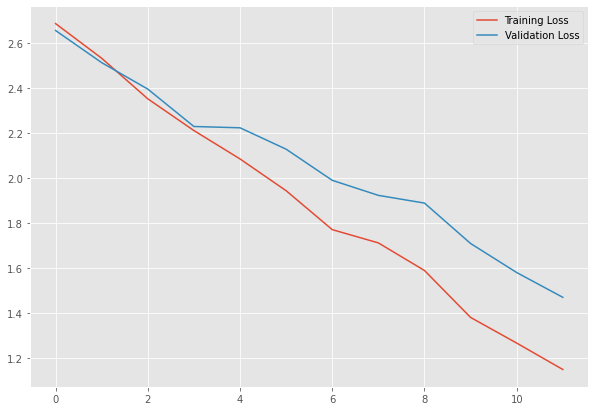

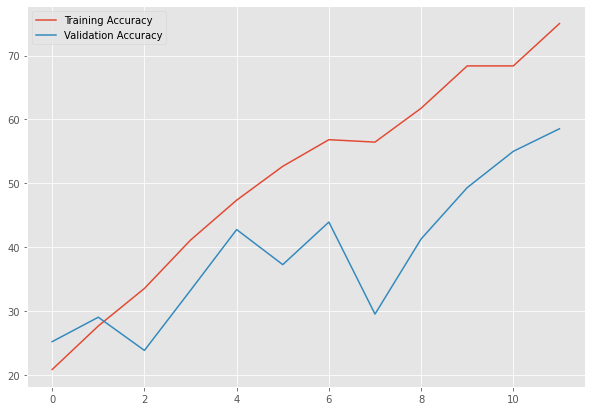

In [53]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model.load_state_dict(torch.load('/content/nfnet6.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.00      0.00      0.00         2
     Ascaris lumbricoides       1.00      0.75      0.86         4
      Cryptosporidium sp.       1.00      0.50      0.67         2
  Cyclospora cayetanensis       0.75      0.75      0.75         4
  Dibothriocephalus latus       0.00      0.00      0.00         3
   Entamoeba histolytica]       0.44      1.00      0.62         4
  Enterobius vermicularis       0.00      0.00      0.00         2
       Giardia duodenalis       0.50      0.25      0.33         4
    Plasmodium falciparum       0.67      0.40      0.50         5
      Plasmodium malariae       0.40      0.50      0.44         4
         Plasmodium ovale       0.25      0.33      0.29         3
         Plasmodium vivax       0.60      0.60      0.60         5
          Sarcocystis sp.       0.50      0.50      0.50         2
Strongyloides stercoralis       0.50      0.33      0.40     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


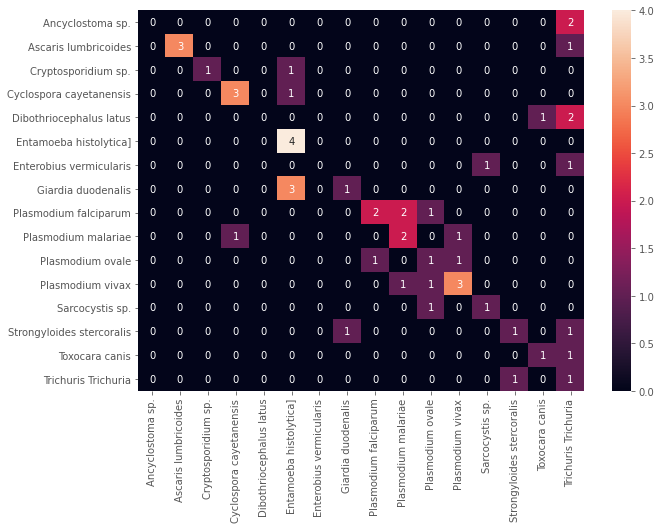

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()